In [1]:
import os
from pathlib import Path

import preprocess
import seaborn as sb
import spacy
import wordcloud
from typing import List
from spacy import displacy

In [2]:
def collect_policies(path: Path | str) -> dict[str, list[str]]:
    """Collects all privacy policies in a directory.

    Args:
        path (Path | str): Path to privacy policies.

    Returns:
        dict[str, list[str]]: A `dict` mapping language to a list of privacy policies.
    """
    raw_texts: list[str] = []

    for parent, _, files in os.walk(path):
        for filename in files:
            # Only collect files ending in `.txt`.
            if filename.split(".")[-1] != "txt":
                continue
            with open(f"{parent}/{filename}", "r") as file:
                for chunk in preprocess.split(file.read(), preprocess.MAX_JA_CHUNK_LEN):
                    raw_texts.append(chunk)

    classified: dict[str, list[str]] = {}
    for text in raw_texts:
        lang = preprocess.classify(text)
        try:
            classified[lang].append(text)
        except KeyError:
            classified[lang] = []
    return classified

In [3]:
preprocess.process(["你好！我喜欢中文。"], "cn")[0]

,token,head,ent_type,ent_status,pos,is_digit,is_punct,is_sent_start,is_sent_end,is_bracket,is_quote,like_url,like_num,like_email,is_stop
0,你好,你好,,O,VERB,False,False,True,False,False,False,False,False,False,False
1,！,你好,,O,PUNCT,False,True,False,True,False,False,False,False,False,True
2,我,喜欢,,O,PRON,False,False,True,False,False,False,False,False,False,True
3,喜欢,喜欢,,O,VERB,False,False,False,False,False,False,False,False,False,False
4,中文,喜欢,LANGUAGE,B,NOUN,False,False,False,False,False,False,False,False,False,False
5,。,喜欢,,O,PUNCT,False,True,False,True,False,False,False,False,False,True


In [4]:
pols = collect_policies(Path("../crawler/policies"))

In [5]:
{k: len(v) for (k, v) in pols.items()}

{'zh-hant': 7, 'zh-hans': 26, 'en': 1, 'ja': 29, 'ko': 30}

In [6]:
cn_docs = preprocess.process_spacy(pols["zh-hant"] + pols["zh-hans"],"cn") 
ja_docs = preprocess.process_spacy(pols["ja"],"ja") 
ko_docs = preprocess.process_spacy(pols["ko"],"ko") 

In [7]:
displacy.render(ja_docs[10][:400], style="ent")

In [8]:
displacy.render(cn_docs[10][:100], style="dep")

In [9]:
def toks_per_sent(docs: List[spacy.tokens.Doc]) -> List[int]:
    """Calculates the number of tokens in each sentence.

    Args:
        docs (List[spacy.tokens.Doc]): A list of spacy `Doc`s to analyze.

    Returns:
        List[int]: A list of tokens per sentence.
    """
    return [len(sent) for doc in docs for sent in doc.sents]

<Axes: >

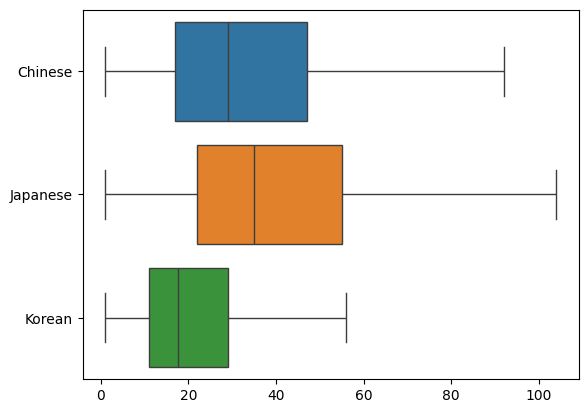

In [10]:
sb.boxplot(
    {
        "Chinese": toks_per_sent(cn_docs),
        "Japanese": toks_per_sent(ja_docs),
        "Korean": toks_per_sent(ko_docs),
    },
    orient="y",
    showfliers=False,
)

In [11]:
def get_freqs(text: list[str]) -> dict[str, int]:
    freq = {}
    for entry in text:
        if freq.get(entry) is None:
            freq[entry] = 1
        else:
            freq[entry] += 1
    return freq

In [12]:
# Replace this with the path to the font to use on your system
font_path = "/usr/share/fonts/noto-cjk/NotoSansCJK-Regular.ttc"

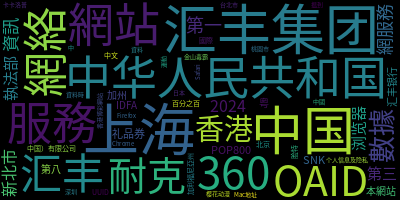

In [13]:
# Chinese
cloud = wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs(
    [ent.text for doc in cn_docs for ent in doc.ents if ent.label_ != "CARDINAL"]
)
cloud.generate_from_frequencies(freqs)
cloud.to_image()

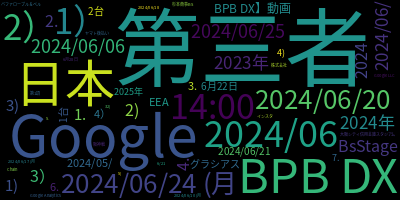

In [14]:
# Japanese
cloud = wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs(
    [ent.text for doc in ja_docs for ent in doc.ents if ent.label_ != "CARDINAL"]
)
cloud.generate_from_frequencies(freqs)
cloud.to_image()

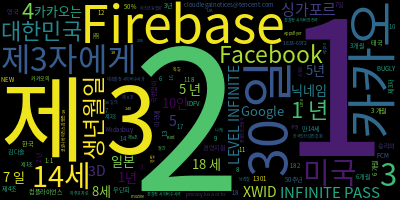

In [15]:
# Korean
cloud = wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs(
    [ent.text for doc in ko_docs for ent in doc.ents if ent.label_ != "CARDINAL"]
)
cloud.generate_from_frequencies(freqs)
cloud.to_image()